In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import requests
import pylab
%pylab inline
import pandas as pd
import re

PRINT_H = False

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# input data
df = pd.read_csv("pima-extract.csv", sep="|").fillna('')
# REMOVE entries with ipv6
df2 = df[df['ip.src']!=''][['frame.time_relative', 'ip.src', 'dns.qry.name']]
df2.head()

,frame.time_relative,ip.src,dns.qry.name
0,0.000000,24.9.76.250,android.clients.google.com
1,0.000001,69.241.95.82,e3645.b.akamaiedge.net
2,0.000005,24.9.76.250,android.clients.google.com
3,0.000009,24.9.76.250,android.clients.google.com
4,0.000010,73.153.66.183,www.polls.newsvine.com


In [3]:
# window by time function
def window_df(df, win):
    '''returns a list of windowed dataframes given original df and window value (in time seconds)'''
    windowed = []
    MAX_T = round( df.iloc[-1]['frame.time_relative'] )
    for t in np.arange(0, MAX_T, win):
        df_win = df [ (df['frame.time_relative'] >= t) & (df['frame.time_relative'] < (t+win)) ]
        windowed.append(df_win)
    return windowed

In [25]:
# TEST
list_wind = window_df( df2, 10 )
print len(list_wind)
print len(list_wind[5])
#list_wind[5]

6
346794


In [5]:
# split by srcip - each home is a node in the tree
def dns_per_src(df):
    '''input df[time, src, dns] output dict{ src: [dns] }'''
    grp = df.groupby('ip.src')
    dict_of_domains = grp['dns.qry.name'].aggregate(lambda x: list(set(x))).to_dict()
    return dict_of_domains

In [6]:
# TEST
dns_per_src(df2.head(30))

{'107.2.42.58': ['profile.ess.apple.com'],
 '24.9.76.250': ['android.clients.google.com'],
 '50.134.220.221': ['teredo.ipv6.microsoft.com'],
 '50.170.152.251': ['t.appsflyer.com'],
 '50.183.21.69': ['p04-imap.mail.me.com.akadns.net'],
 '50.183.81.160': ['lucy.corp.netopia.com'],
 '67.190.144.191': ['sync.syngenta.com'],
 '69.241.95.82': ['e3645.b.akamaiedge.net'],
 '69.241.95.86': ['dsn2.skype-dsn.akadns.net'],
 '69.244.58.56': ['tvxlgp-br-c494.lp.xcal.tv'],
 '69.252.212.70': ['_ldap._tcp.pdc._msdcs.mii.com'],
 '69.252.212.82': ['e.5.0.b.8.a.e.f.f.f.a.b.6.7.6.6.7.8.9.2.0.0.0.4.0.8.2.0.1.0.6.2.ip6.arpa'],
 '71.56.196.188': ['secure.insightexpressai.com'],
 '73.14.136.124': ['wpad.corp.intranet'],
 '73.153.66.183': ['www.polls.newsvine.com'],
 '73.24.236.171': ['go.aniview.com',
  'lb-adselect-344315156.us-west-2.elb.amazonaws.com'],
 '73.34.159.53': ['content.tegna-media.com'],
 '73.34.180.29': ['www.telegraph.co.uk'],
 '73.34.207.26': ['_ldap._tcp.pdc._msdcs.mii.com'],
 '73.78.52.192':

In [7]:
def split_domain(domain):
    '''input domain return split domain at find every "." 
    eg: cs.princeton.edu -> ['cs.princeton.edu', 'princeton.edu', 'edu']
    then reverse it before adding it to tree'''
    
    node_list = [domain]
    for m in re.finditer('\.', domain):
        node_list.append( domain[m.end():] )
    
    node_list.reverse()
    
    return node_list

In [8]:
# TEST
dom = 'cs.princeton.edu'
split_domain(dom)

['edu', 'princeton.edu', 'cs.princeton.edu']

In [9]:
def add_branch(G, srcip, list_of_dns):
    '''create tree graph branch given home IP dns list'''
    # root and add branch to srcip
    G.add_node(srcip)
    G.add_edge('root', srcip)
    if PRINT_H: print 'root', "-->", srcip
    
    # domain split using str.split('.')
    for domain in list_of_dns:
        dom_list = split_domain(domain)
        
        # connect to root (srcip) node
        if not G.has_edge(srcip, dom_list[0]):
            G.add_edge(srcip, dom_list[0])
            if PRINT_H: print "\t", srcip, "-->", dom_list[0]
            
        # add list of split domains to a branch in tree
        for i in range(len(dom_list)-1):
            if not G.has_node(dom_list[i]):
                G.add_node(dom_list[i])
            if not G.has_node(dom_list[i+1]):
                G.add_node(dom_list[i+1])
            if not G.has_edge(dom_list[i], dom_list[i+1]):
                G.add_edge(dom_list[i], dom_list[i+1])
                if PRINT_H: print "\t\t", dom_list[i], "-->", dom_list[i+1]
    return

In [20]:
def draw_domain_tree(G):
    # print graph
    G2 = nx.Graph(nx.prim_mst_edges(G))
    #pos=nx.spring_layout(G2)
    #nx.set_node_attributes(G2,'pos',pos)
    #T = nx.bfs_tree(G2, 'root')

    plt.figure()
    nx.draw(G2, with_labels=True)
    #nx.draw(T, with_labels=True)
    plt.show()
    return

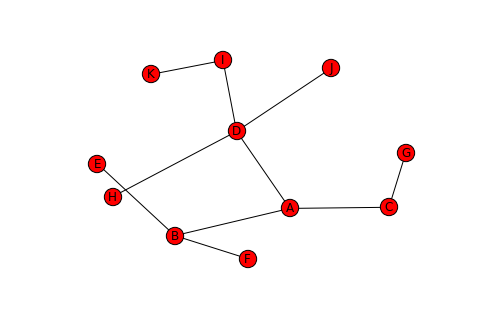

In [21]:
#TEST
G = nx.Graph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')
G.add_node('E')
G.add_node('F')
G.add_node('G')
G.add_node('H')
G.add_node('I')
G.add_node('J')
G.add_node('K')
G.add_node('A')

G.add_edge('A', 'B')
G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('A', 'D')
G.add_edge('B', 'E')
G.add_edge('B', 'F')
G.add_edge('C', 'G')
G.add_edge('D', 'H')
G.add_edge('D', 'I')
G.add_edge('D', 'J')
G.add_edge('I', 'K')

draw_domain_tree(G)

In [26]:
def create_domain_tree(df):
    '''input dataframe of [time, srcip, dns]
    output tree'''
    
    G = nx.Graph()
    G.add_node('root')
    
    # 1. get dns list per source ip
    src_domain_dict = dns_per_src(df)
    
    # 2. for every srcip, add it to tree and add its branch to tree
    for srcip, domain_list in src_domain_dict.iteritems():
        add_branch(G, srcip, domain_list)

    return G

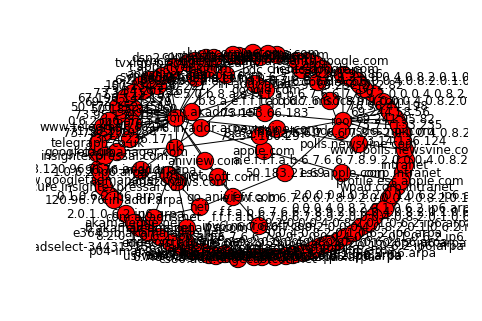

In [27]:
test_df = df2.head(30)

G = create_domain_tree(test_df)
draw_domain_tree(G)

## TODO
- might need to replace networkx with ete3 Tree for better layout
- http://etetoolkit.org/

# Window every 5 sec

In [28]:
windowed = window_df(df2, 5.0)
print len(windowed)

12


In [ ]:
G1 = create_domain_tree(windowed[0])
draw_domain_tree(G1)

# TEST

In [ ]:
#T = nx.dfs_tree(G, 'A')
G2 = nx.Graph(nx.prim_mst_edges(G))
T = nx.bfs_tree(G2, 'A')
#T = nx.minimum_spanning_tree(G)

plt.figure()
#nx.draw(G, with_labels=True)
nx.draw(T, with_labels=True)
plt.show()

In [ ]:
G.has_node('A')

In [ ]:
x = '123.112.111.111'
t = x.find('.')
node = x[:t]
print node
x2 = x[t+1:]
t = x2.find('.')
print x2[:t]
print x2[t+1:]

In [ ]:
btree = nx.balanced_tree(2,4)
pos=nx.drawing.nx_agraph.graphviz_layout(btree,prog='dot')
nx.draw(btree,pos,with_labels=False,arrows=False)

In [ ]:
import networkx as nx

g=nx.DiGraph()
g.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9),
                  (4,10), (5,11), (5,12), (6,13)])
nx.drawing.nx_pydot.to_pydot(g)

In [ ]:
G = nx.Graph()



plt.figure()
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
G = nx.Graph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')
G.add_node('E')
G.add_node('F')
G.add_node('G')
G.add_node('H')
G.add_node('I')
G.add_node('J')
G.add_node('K')

G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('A', 'D')
G.add_edge('B', 'E')
G.add_edge('B', 'F')
G.add_edge('C', 'G')
G.add_edge('D', 'H')
G.add_edge('D', 'I')
G.add_edge('D', 'J')
G.add_edge('I', 'K')

T = nx.depth_first_search.dfs_tree(G, 'A')
#T = nx.minimum_spanning_tree(G)

plt.figure()
nx.draw(G, with_labels=True)
#nx.draw(T, with_labels=True)
plt.show()